In [234]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize
from scipy import stats as sps

import pandas as pd

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [235]:
def explicit_scheme(y0, tn, lam):
    res = np.zeros_like(tn) + y0
    for i in range(len(tn) - 1):
        tau = tn[i + 1] - tn[i]
        res[i + 1] = res[i] * (1 + lam * tau)
    return res


def implicit_scheme(y0, tn, lam):
    res = np.zeros_like(tn) + y0
    for i in range(len(tn) - 1):
        tau = tn[i + 1] - tn[i]
        res[i + 1] = res[i] / (1 - lam * tau)
    return res


def mid_term_scheme(y0, tn, lam):
    res = np.zeros_like(tn) + y0
    for i in range(len(tn) - 1):
        tau = tn[i + 1] - tn[i]
        res[i + 1] = (1 + 0.5 * lam * tau) / (1 - 0.5 * lam * tau) * res[i]
    return res

In [236]:
y0 = 1
tn_true = np.linspace(0, 1, 10000)
exact = lambda y0, tn, lam: y0 * np.exp(lam * tn)

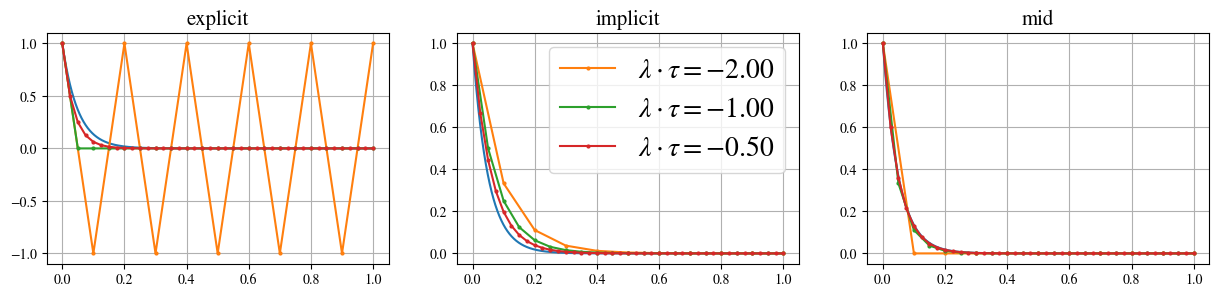

In [239]:
lam = -20
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

schemes = {"explicit" : explicit_scheme, "implicit" : implicit_scheme, "mid" : mid_term_scheme}

for i, (name, scheme) in enumerate(schemes.items()):
    ax[i].set_title(name, fontsize=15)
    ax[i].plot(tn_true, exact(y0, tn_true, lam))
    tn, tau = np.linspace(0, 1, 11, retstep=True)
    ax[i].plot(tn, scheme(y0, tn, lam), '-o', ms=2, label=fr'$\lambda \cdot \tau = {tau * lam : 0.2f}$')
    tn, tau = np.linspace(0, 1, 21, retstep=True)
    ax[i].plot(tn, scheme(y0, tn, lam), '-o', ms=2, label=fr'$\lambda \cdot \tau = {tau * lam : 0.2f}$')
    tn, tau = np.linspace(0, 1, 41, retstep=True)
    ax[i].plot(tn, scheme(y0, tn, lam), '-o', ms=2, label=fr'$\lambda \cdot \tau = {tau * lam : 0.2f}$')
    #ax[i].set_ylim(0, 1)
    ax[i].grid()
ax[1].legend(fontsize=20)
plt.show()

In [5]:
from collections import defaultdict
from tqdm.notebook import tqdm

In [6]:
schemes = {"explicit" : explicit_scheme, "implicit" : implicit_scheme, "mid" : mid_term_scheme}
nts = 10 * (2 ** np.arange(11))

errors = defaultdict(list)

for name, scheme in schemes.items():
    for nt in nts:
        tn, tau = np.linspace(0, 1, nt, retstep=True)
        solution = scheme(y0, tn, lam)
        true = exact(y0, tn, lam)
        errors[name].append(np.linalg.norm(solution - true) * np.sqrt(tau))
    errors[name] = np.array(errors[name])
errors = pd.DataFrame(errors)

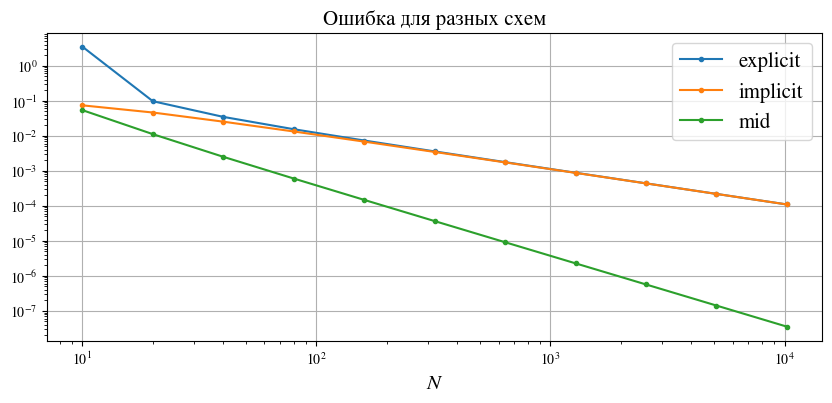

In [7]:
plt.figure(figsize=(10, 4))
plt.title("Ошибка для разных схем", fontsize=15)
plt.loglog(nts, errors, '-o', ms=3)
plt.legend(schemes.keys(), fontsize=15)
plt.grid()
plt.xlabel(r"$N$", fontsize=15)
plt.show()

## Биноминальное дерево

In [170]:
from dataclasses import dataclass

@dataclass
class BinomParams:
    T : float
    r : float
    sigma : float
    nt : int
        
    def __post_init__(self):
        self.tau = self.T / self.nt
        self.u = np.exp(self.r * self.tau + self.sigma * np.sqrt(self.tau))
        self.d = np.exp(self.r * self.tau - self.sigma * np.sqrt(self.tau))
        self.q = (np.exp(self.r * self.tau) - self.d) / (self.u - self.d)
    
    def get_probs(self):
        return [self.q, 1 - self.q]
    

@dataclass
class BinomParams:
    T : float
    r : float
    sigma : float
    S : float
    nt : int
    
        
    def __post_init__(self):
        self.tau = self.T / self.nt
        self.u = np.exp(self.r * self.tau + self.sigma * np.sqrt(self.tau))
        self.d = np.exp(self.r * self.tau - self.sigma * np.sqrt(self.tau))
        self.q = (np.exp(self.r * self.tau) - self.d) / (self.u - self.d)
        self.df = np.exp(-r * self.tau)

    def get_probs(self):
        return np.r_[self.q, 1 - self.q]
    
    def get_stock_prices(self, step):
        states = np.arange(step + 1)
        stock_prices = self.S * (self.d ** (step - states)) * (self.u ** states)
        return stock_prices

    def diffuse(self, values):
        q1, q2 = self.get_probs()
        return self.df * (q1 * values[1:] + q2 * values[:-1])

    
@dataclass
class TrinomParams:
    T : float
    r : float
    sigma : float
    S : float
    nt : int
    
    def __post_init__(self):
        self.tau = self.T / self.nt
        self.df = np.exp(-self.r * self.tau)
        u = np.exp(self.sigma * np.sqrt(3 * self.tau))
        d = 1 / u
        self.q1 = (np.exp(self.sigma ** 2 * self.tau) - 1) / ((u-1)*(u-d))
        self.q3 = (np.exp(self.sigma ** 2 * self.tau) - 1) / ((1-d)*(u-d))
        self.q2 = 1 - self.q1 - self.q3
        self.u = u * np.exp(self.r * self.tau)
        self.d = d * np.exp(self.r * self.tau)
        
    def get_probs(self):
        return np.r_[self.q1, self.q2, self.q3]

    def get_stock_prices(self, step):
        states = np.arange(-step, step + 1)
        x = self.r * self.tau * step + self.sigma * np.sqrt(self.tau * 3) * states
        return self.S * np.exp(x)
        
        
    def diffuse(self, values):
        q1, q2, q3 = self.get_probs()
        return self.df * (q1 * values[2:] + q2 * values[1:-1] + q3 * values[:-2])

In [171]:
def get_option_price(params, payoff_func, is_euro=True):
    states = params.get_stock_prices(params.nt)
    price = payoff_func(states)
    
    for t in range(params.nt)[::-1]:
        states = params.get_stock_prices(t)
        payoff = payoff_func(states)
        cont_value = params.diffuse(price)
        if is_euro:
            price = cont_value
        else:
            price = np.maximum(cont_value, payoff)
    return price[0]

In [198]:
from scipy import stats as sps
def get_BS_call_price(S, r, sigma, K, T):
    df = np.exp(-r * T)
    forw = S / df
    theta = np.sqrt(T) * sigma
    
    d1 = np.log(forw / K) / theta + 0.5 * theta
    d2 = np.log(forw / K) / theta - 0.5 * theta
    
    N1 = sps.norm.cdf(d1)
    N2 = sps.norm.cdf(d2)
    
    return S * N1 - df * K * N2


def get_BS_put_price(S, r, sigma, K, T):
    return get_BS_call_price(S, r, sigma, K, T) - (S - K * np.exp(-r * T))

In [190]:
r = 0.1
sigma = 0.2
T = 1.0
S = 100.0

binom_params = BinomParams(T, r, sigma, S, 10)
trinom_params = TrinomParams(T, r, sigma, S, 10)

In [191]:
K = 100.0
call_payoff = lambda x: (x - K).clip(0.0)
put_payoff = lambda x: (K - x).clip(0.0)
true_price = get_BS_call_price(S, r, sigma, K, T)
true_price, get_option_price(binom_params, call_payoff, is_euro=True), get_option_price(trinom_params, call_payoff, is_euro=True)

(np.float64(13.269676584660893),
 np.float64(13.32278448094015),
 np.float64(13.18633924869046))

In [193]:
nts = 10 * (2 ** np.arange(0, 13))
binom_params = [BinomParams(T, r, sigma, S, nt) for nt in nts]
binom_prices = np.array([get_option_price(prms, payoff_func, is_euro=True) for prms in tqdm(binom_params)])

trinom_params = [TrinomParams(T, r, sigma, S, nt) for nt in nts]
trinom_prices = np.array([get_option_price(prms, payoff_func, is_euro=True) for prms in tqdm(trinom_params)])

In [180]:
trinom_prices

array([13.18633925, 13.28655305, 13.2649659 , 13.27942092, 13.27354848,
       13.26870445, 13.27035695, 13.27009146, 13.26995931, 13.26979239,
       13.26967662, 13.2696999 , 13.26969549])

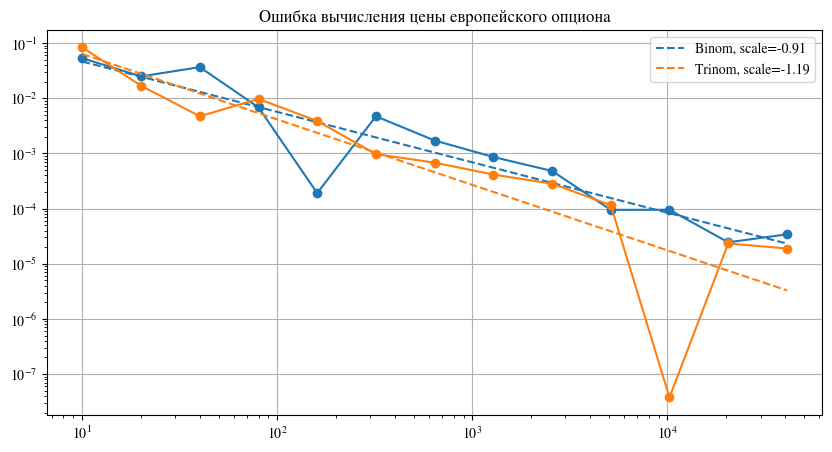

In [215]:
plt.figure(figsize=(10, 5))
plt.title("Ошибка вычисления цены европейского опциона")
error = np.abs(binom_prices - true_price)
x, y = np.log(nts), np.log(error)
scale, loc = np.polyfit(x, y, 1)
plt.loglog(nts, error, '-o', color='C0')
plt.loglog(nts, np.exp(x * scale + loc), '--', color='C0', label=f'Binom, scale={scale:0.2f}')

error = np.abs(trinom_prices - true_price)
x, y = np.log(nts), np.log(error)
scale, loc = np.polyfit(x, y, 1)
plt.loglog(nts, error, '-o', color='C1')
plt.loglog(nts, np.exp(x * scale + loc), '--', color='C1', label=f'Trinom, scale={scale:0.2f}')
plt.legend()
plt.grid()
plt.show()

In [182]:
def get_order_estimation(nts, prices):
    error = np.abs(prices[1:] - prices[:-1])
    x = np.log(nts[1:])
    y = np.log(error)
    scale, loc = np.polyfit(x, y, 1)
    return -scale

get_order_estimation(nts, binom_prices), get_order_estimation(nts, trinom_prices)

(np.float64(1.068539151276162), np.float64(1.1908374268048243))

In [194]:
binom_prices_american = np.array([get_option_price(prms, put_payoff, is_euro=False) for prms in tqdm(binom_params)])
trinom_prices_american = np.array([get_option_price(prms, put_payoff, is_euro=False) for prms in tqdm(trinom_params)])

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [199]:
get_order_estimation(nts, binom_prices_american), get_order_estimation(nts, trinom_prices_american)

(np.float64(1.0428394739124496), np.float64(1.0317399469873627))

In [204]:
nt = 1000

binom_params = BinomParams(T, r, sigma, S, nt)
trinom_params = TrinomParams(T, r, sigma, S, nt)

strikes = np.linspace(0.7, 1.3) * S
prices = {
    'euro' : np.zeros_like(strikes),
    'binom' : np.zeros_like(strikes),
    'trinom' : np.zeros_like(strikes)
}
for i, strike in enumerate(tqdm(strikes)):
    payoff = lambda x: (strike - x).clip(0.0)
    prices['euro'][i] = get_BS_put_price(S, r, sigma, strike, T)
    prices['binom'][i] = get_option_price(binom_params, payoff, False)
    prices['trinom'][i] = get_option_price(trinom_params, payoff, False)

  0%|          | 0/50 [00:00<?, ?it/s]

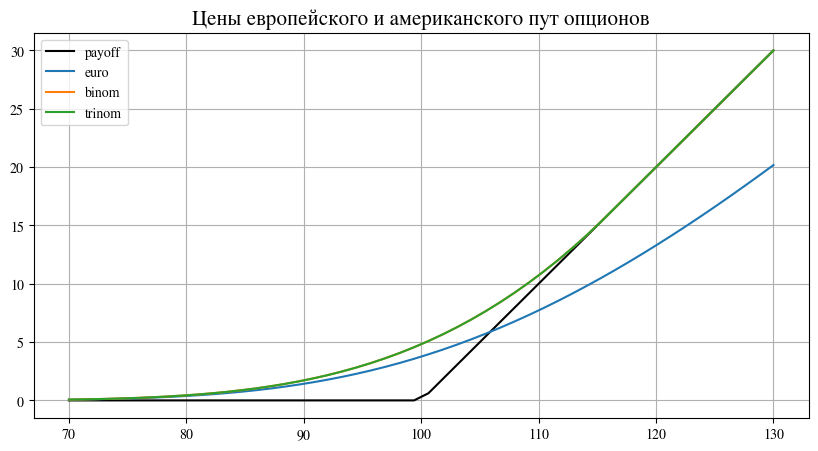

In [217]:
plt.figure(figsize=(10, 5))
plt.title("Цены европейского и американского пут опционов", fontsize=15)
plt.plot(strikes, (strikes - S).clip(0.0), color='black', label='payoff')
for c in prices:
    plt.plot(strikes, prices[c], label=c)
plt.legend()
plt.grid()
plt.show()

## Апостериорное улучшение точности

In [240]:
def richardson_iteration(Ns, I, p):
    I = np.array(I)
    # оценка ошибки
    R = np.zeros(len(Ns))
    # формула Ричардсона
    R[1:] = (I[:-1] - I[1:]) / (2 ** p - 1)
    # экстраполяция ошибки R_N
    R[0] = R[1] * (2 ** p)
    return R


def richardrson(Ns, I, p, inc=1, niter=None):
    # число итераций метода Ричарсдона
    if niter is None:
        niter = len(Ns) - 1
    # оценки интегралов
    integrals = [I]
    # оценки ошибок
    errors = []
    for i in range(niter):
        # оценка ошибки предыдущего интеграла (I)
        R = richardson_iteration(Ns, I, p + i * inc)
        # новое значение интеграла Inew = I - R
        I = I - R
        # сохраняем данные
        integrals.append(I)
        errors.append(R)
    return np.array(integrals), np.array(errors)

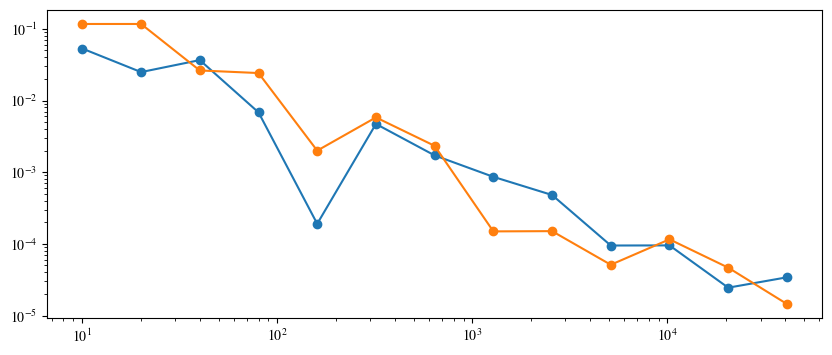

In [306]:
euro_richardson = trinom_prices - richardson_iteration(nts, trinom_prices, 1)
american_richardson = richardson_iteration(nts, binom_prices_american, 1)

plt.figure(figsize=(10, 4))
plt.loglog(nts, np.abs(binom_prices - true_price).T, '-o')
plt.loglog(nts, np.abs(euro_richardson - true_price).T, '-o')

## Numba

In [218]:
import numba as nb

In [225]:
@nb.njit
def diffuse(values, q1, q2, df):
    return df * (q1 * values[1:] + q2 * values[:-1])

@nb.njit
def get_put_price(S, strike, u, d, q1, q2, df, nt, is_euro=False):
    # your code here
    states = np.arange(nt + 1)    
    stock_prices = S * (u ** (nt - states)) * (d ** states)
    price = np.maximum(0, (strike - stock_prices))
    for t in range(nt - 1, -1, -1):
        states = np.arange(t + 1)
        stock_prices = S * (u ** (t - states)) * (d ** states)
        price = diffuse(price, q1, q2, df)
        if not is_euro:
            payoff = np.maximum(0, (strike - stock_prices))
            price = np.maximum(price, payoff)
    return price[0]

In [231]:
K = 100.0
nt = 10000
params = BinomParams(T, r, sigma, S, nt)
get_put_price(S, K, params.u, params.d, *params.get_probs(), params.df, params.nt)

4.117949811476171

In [232]:
%%timeit
get_put_price(S, K, params.u, params.d, *params.get_probs(), params.df, params.nt)

4.7 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [233]:
%%timeit
get_option_price(params, put_payoff, is_euro=False)

4.13 s ± 83.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
